In [27]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [28]:
WINDOW = 8  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '1y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock

# one day 16 rows of data

In [29]:
data = yf.download(  # or pdr.get_data_yahoo(...
    tickers=symbol,

    period=INTERVAL,

    interval=FETCH_INTERVAL,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    # auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=True,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy=None
)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.9750,77.9750,0
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.9775,77.9775,0
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.2450,78.2450,0
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.1125,78.1125,0
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.3225,78.3225,0
...,...,...,...,...,...,...
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.8200,122.8200,14469408
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.4000,122.4000,0
2021-05-12 17:00:00-04:00,122.360000,124.524100,113.934780,122.4600,122.4600,0


In [30]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low', 'close', 'volume']

In [31]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [32]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [33]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

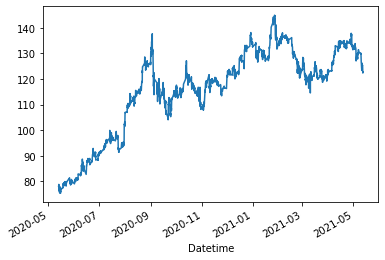

In [34]:
data['close'].plot()

In [35]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-13 04:00:00-04:00,77.7525,77.9750,77.6875,77.9750,77.9750,0,NaN
2020-05-13 05:00:00-04:00,77.9750,78.2475,77.9000,77.9775,77.9775,0,0.000032
2020-05-13 06:00:00-04:00,77.9975,78.2700,77.9975,78.2450,78.2450,0,0.003430
2020-05-13 07:00:00-04:00,78.2050,78.2975,78.0175,78.1125,78.1125,0,-0.001693
2020-05-13 08:00:00-04:00,78.1175,78.5000,78.0050,78.3225,78.3225,0,0.002688


In [36]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4.187000e+03,4186.000000
mean,115.495982,116.040516,114.850457,115.493613,115.493613,5.080393e+06,0.000123
std,16.805333,17.645432,16.756622,16.792796,16.792796,8.586368e+06,0.005409
min,75.087502,75.537500,58.360000,75.300000,75.300000,0.000000e+00,-0.051319
25%,109.368750,109.762300,108.672499,109.335575,109.335575,0.000000e+00,-0.001888
50%,119.650902,120.100000,118.812500,119.639900,119.639900,0.000000e+00,0.000090
75%,128.270051,128.702501,127.591200,128.269249,128.269249,8.373736e+06,0.002269
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [37]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [38]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.9750,77.9750,0,NaN
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.9775,77.9775,0,0.000032
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.2450,78.2450,0,0.003430
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.1125,78.1125,0,-0.001693
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.3225,78.3225,0,0.002688
...,...,...,...,...,...,...,...
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.8200,122.8200,14469408,0.002858
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.4000,122.4000,0,-0.003420
2021-05-12 17:00:00-04:00,122.360000,124.524100,113.934780,122.4600,122.4600,0,0.000490


In [39]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [40]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [41]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.9750,77.9750,0,NaN,0.000000e+00,0,0.000000,...,0.000000,77.975000,0.000000,0.000000,0.000000,0.000000,-32.485444,0.000000,0.000000,76.611198
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.9775,77.9775,0,0.000032,0.000000e+00,0,0.000000,...,0.000000,77.976113,0.000000,0.000000,0.000000,0.000000,0.003206,0.003206,0.003206,76.374977
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.2450,78.2450,0,0.003430,0.000000e+00,0,0.000000,...,0.000000,78.093408,0.000000,0.000000,0.000000,0.000000,0.343048,0.342461,0.346265,76.417747
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.1125,78.1125,0,-0.001693,0.000000e+00,0,0.000000,...,0.000000,78.101618,0.000000,0.000000,0.000000,0.000000,-0.169340,-0.169483,0.176339,76.184998
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.3225,78.3225,0,0.002688,0.000000e+00,0,0.000000,...,0.000000,78.194854,0.000000,0.000000,0.000000,0.000000,0.268843,0.268482,0.445656,76.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.8200,122.8200,14469408,0.002858,6.359432e+08,-499096534,-0.139414,...,-1.694206,122.794127,-1.947949,23.803451,9.532677,14.270774,0.285783,0.285375,57.512023,NaN
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.4000,122.4000,0,-0.003420,6.359432e+08,-499096534,-0.227993,...,-1.715150,122.682449,-2.384560,13.137307,10.253603,2.883705,-0.341964,-0.342550,56.973389,NaN
2021-05-12 17:00:00-04:00,122.360000,124.524100,113.934780,122.4600,122.4600,0,0.000490,6.359432e+08,-499096534,-0.272966,...,-2.377450,122.624161,-2.196310,3.390093,8.880901,-5.490808,0.049020,0.049008,57.050337,NaN


In [42]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                      axis=1)
    print(df['class_column'].value_counts())
    return df


data = create_class(data)

data


 1    1397
 0    1395
-1    1395
Name: class_column, dtype: int64


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-05-13 04:00:00-04:00,77.752500,77.975000,77.687500,77.9750,77.9750,0,NaN,0.000000e+00,0,0.000000,...,77.975000,0.000000,0.000000,0.000000,0.000000,-32.485444,0.000000,0.000000,76.611198,-1
2020-05-13 05:00:00-04:00,77.975000,78.247500,77.900000,77.9775,77.9775,0,0.000032,0.000000e+00,0,0.000000,...,77.976113,0.000000,0.000000,0.000000,0.000000,0.003206,0.003206,0.003206,76.374977,-1
2020-05-13 06:00:00-04:00,77.997500,78.270000,77.997500,78.2450,78.2450,0,0.003430,0.000000e+00,0,0.000000,...,78.093408,0.000000,0.000000,0.000000,0.000000,0.343048,0.342461,0.346265,76.417747,-1
2020-05-13 07:00:00-04:00,78.205000,78.297500,78.017500,78.1125,78.1125,0,-0.001693,0.000000e+00,0,0.000000,...,78.101618,0.000000,0.000000,0.000000,0.000000,-0.169340,-0.169483,0.176339,76.184998,-1
2020-05-13 08:00:00-04:00,78.117500,78.500000,78.005000,78.3225,78.3225,0,0.002688,0.000000e+00,0,0.000000,...,78.194854,0.000000,0.000000,0.000000,0.000000,0.268843,0.268482,0.445656,76.919998,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 15:30:00-04:00,122.474998,123.059998,122.300003,122.8200,122.8200,14469408,0.002858,6.359432e+08,-499096534,-0.139414,...,122.794127,-1.947949,23.803451,9.532677,14.270774,0.285783,0.285375,57.512023,NaN,0
2021-05-12 16:00:00-04:00,122.820000,123.090000,122.345000,122.4000,122.4000,0,-0.003420,6.359432e+08,-499096534,-0.227993,...,122.682449,-2.384560,13.137307,10.253603,2.883705,-0.341964,-0.342550,56.973389,NaN,0
2021-05-12 17:00:00-04:00,122.360000,124.524100,113.934780,122.4600,122.4600,0,0.000490,6.359432e+08,-499096534,-0.272966,...,122.624161,-2.196310,3.390093,8.880901,-5.490808,0.049020,0.049008,57.050337,NaN,0


In [43]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_1y_8_diff_13_05_2021 10_13_15_full.csv


In [44]:

# Class divide
data['class_column'].value_counts()

 1    1397
 0    1395
-1    1395
Name: class_column, dtype: int64

In [45]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [46]:
data['class_column'].value_counts()


 1    1397
-1    1394
 0    1387
Name: class_column, dtype: int64

In [47]:
def split_dataframe(df, chunk_size=17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size:(i + 1) * chunk_size])
    return chunks


def train_model(model, train_x, train_y):
    model.fit(train_x, train_y)

In [48]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

246

In [49]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [50]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=20, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='gini',
                                                                 splitter='random')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='entropy',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(max_depth=15, random_state=0, criterion='entropy',
                                                                 splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
                                                                 criterion='gini', n_jobs=-1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,
                                                                 criterion='entropy', n_jobs=-1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                         criterion='friedman_mse', max_depth=10,
                                                                         learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.1)
classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.2)
classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=14, n_estimators=1000, eta=0.3)
classifiers['XGBClassifier 3'] = xgb.XGBClassifier(nthread=-1, max_depth=14, n_estimators=1000, eta=0.2)
classifiers['XGBClassifier 4'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.5)
classifiers['XGBClassifier 5'] = xgb.XGBClassifier(nthread=-1, max_depth=6, n_estimators=1000, eta=0.3)
classifiers['XGBClassifier 6'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=12, n_estimators=100, eta=0.4)
classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=14, n_estimators=100, eta=0.4)
classifiers['XGBRFClassifier 3'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=3, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 4'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=6, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 5'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=10, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 6'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=10, n_estimators=100, eta=0.4)
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1S'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=3,
                                                                                  learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2S'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=3,
                                                                                  learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3S'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=2,
                                                                                  learning_rate=0.5)
# classifiers_boosted['GradientBoostingClassifier 4S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)



In [51]:
def count_correct(pred_list, original_list):
    correct_inc = 0
    correct_dec = 0
    correct_stag = 0
    all = len(pred_list)
    all_inc = 0
    all_dec = 0
    all_stag = 0
    for idx, el in enumerate(pred_list):
        if original_list[idx] == 1:
            all_inc += 1
            if el == 1:
                correct_inc += 1
        if original_list[idx] == -1:
            all_dec += 1
            if el == -1:
                correct_dec += 1
        if original_list[idx] == 0:
            all_stag += 1
            if el == 0:
                correct_stag += 1
    return correct_inc, correct_dec, correct_stag, all_inc, all_dec, all_stag, all


In [52]:
print(len(splited_dataframe))

246


In [53]:
start_data = splited_dataframe[:100]
next_data = splited_dataframe[100:170]
print(len(next_data))
score = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
for idx, day in enumerate(next_data):
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    print(data_set['class_column'].value_counts())
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train = x.iloc[:-17]
    y_train = y.iloc[:-17]
    x_test = x.iloc[-17:]
    y_test = y.iloc[-17:]

    print(len(data_set))

    step_headers.append(f'<{i}>')
    i = i + 1
    predictions_train = dict()
    predictions = dict()

    for k, v in classifiers.items():
        print("Calculate: ", k)
        train_model(v, x_train, y_train)
        predictions_train[k] = v.predict(x_train)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))

    rfe = RFE(classifiers['RandomForestClassifier 5'], 10)
    fited = rfe.fit(x_train, y_train)
    names = x.columns
    columns = []
    for i in range(len(fited.support_)):
        if fited.support_[i]:
            columns.append(names[i])

    print("Columns with predictive power:", columns)
    columns = columns + ['high', 'low', 'volume', 'open']
    x_test_cropped = x_test[columns]
    x_train_cropped = x_train[columns]
    for k, v in classifiers_boosted.items():
        print("Calculate: ", k)
        train_model(v, x_train_cropped, y_train)
        predictions_train[k] = v.predict(x_train_cropped)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test_cropped)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))




70
start
 1    582
-1    570
 0    565
Name: class_column, dtype: int64
 1    582
-1    570
 0    565
Name: class_column, dtype: int64
1717
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.7647058823529411
Calculate:  GradientBoostingClassifier 2
0.6470588235294118
Calculate:  GradientBoostingClassifier 3
0.5882352941176471
Calculate:  XGBClassifier 1
[10:15:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set ev

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[10:15:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[10:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[10:15:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.35294117647058826
 1    585
-1    578
 0    571
Name: class_column, dtype: int64
 1    585
-1    578
 0    571
Name: class_column, dtype: int64
1734
Calculate:  DecisionTreeClassifier 1
0.17647058823529413
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[10:18:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[10:18:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[10:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volume_nvi', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_trix', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
0.7647058823529411
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    590
-1    581
 0    580
Name: class_column, dtype: int64
 1    590
-1    581
 0    580
Name: class_column, dtype: int64
1751
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.7647058823529411
Calculate:  RandomForestClassifier 5
0.7647058823529411
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  GradientBoostingClassifi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.47058823529411764
Calculate:  XGBClassifier 2
[10:22:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[10:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[10:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_macd', 'trend_trix', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.4117647058823529
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    599
 0    585
-1    584
Name: class_column, dtype: int64
 1    599
 0    585
-1    584
Name: class_column, dtype: int64
1768
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.9411764705882353
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.8823529411764706
Calculate:  GradientBoostingCla

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9411764705882353
Calculate:  XGBClassifier 2
[10:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 3
[10:25:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 4
[10:25:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbl', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.6470588235294118
 1    604
 0    594
-1    587
Name: class_column, dtype: int64
 1    604
 0    594
-1    587
Name: class_column, dtype: int64
1785
Calculate:  DecisionTreeClassifier 1
0.17647058823529413
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calcula

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[10:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[10:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[10:29:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
1.0
 1    612
 0    598
-1    592
Name: class_column, dtype: int64
 1    612
 0    598
-1    592
Name: class_column, dtype: int64
1802
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.6470588235294118
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.6470588235294118
Calculate:  RandomForestClassifier 5
0.5882352941176471
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  GradientBoostingClas

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[10:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[10:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[10:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volume_vwap', 'volatility_atr', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.6470588235294118
Calculate:  GradientBoostingClassifier 2S
0.6470588235294118
Calculate:  GradientBoostingClassifier 3S
0.6470588235294118
 1    616
 0    604
-1    599
Name: class_column, dtype: int64
 1    616
 0    604
-1    599
Name: class_column, dtype: int64
1819
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[10:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[10:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[10:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_trix', 'trend_kst', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.23529411764705882
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.17647058823529413
 1    616
-1    610
 0    610
Name: class_column, dtype: int64
 1    616
-1    610
 0    610
Name: class_column, dtype: int64
1836
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.7058823529411765
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.17647058823529413
Calculat

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[10:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 3
[10:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 4
[10:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_trix', 'trend_kst', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.6470588235294118
Calculate:  GradientBoostingClassifier 2S
0.5294117647058824
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 0    623
 1    616
-1    614
Name: class_column, dtype: int64
 0    623
 1    616
-1    614
Name: class_column, dtype: int64
1853
Calculate:  DecisionTreeClassifier 1
0.6470588235294118
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.35294117647058826
Calculate:  

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.4117647058823529
Calculate:  XGBClassifier 2
[10:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 3
[10:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[10:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_trix', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind']
Calculate:  GradientBoostingClassifier 1S
0.17647058823529413
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.11764705882352941
 1    631
 0    626
-1    613
Name: class_column, dtype: int64
 1    631
 0    626
-1    613
Name: class_column, dtype: int64
1870
Calculate:  DecisionTreeClassifier 1
0.6470588235294118
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate:  GradientB

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[10:46:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[10:46:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 4
[10:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_kcc', 'volatility_dcw', 'trend_macd', 'trend_kst', 'trend_kst_sig', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.5294117647058824
Calculate:  GradientBoostingClassifier 3S
0.5294117647058824
 1    639
 0    630
-1    618
Name: class_column, dtype: int64
 1    639
 0    630
-1    618
Name: class_column, dtype: int64
1887
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.23529411764705882
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  GradientB

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[10:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[10:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[10:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_kcl', 'volatility_dcw', 'trend_macd', 'trend_macd_signal', 'trend_trix', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.47058823529411764
Calculate:  GradientBoostingClassifier 3S
0.5294117647058824
 1    641
 0    638
-1    625
Name: class_column, dtype: int64
 1    641
 0    638
-1    625
Name: class_column, dtype: int64
1904
Calculate:  DecisionTreeClassifier 1
0.5294117647058824
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.11764705882352941
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  GradientBoosti

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[10:54:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 3
[10:54:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 4
[10:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_bbh', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_trix', 'trend_kst_sig', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.17647058823529413
Calculate:  GradientBoostingClassifier 2S
0.29411764705882354
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    651
 0    641
-1    629
Name: class_column, dtype: int64
 1    651
 0    641
-1    629
Name: class_column, dtype: int64
1921
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.35294117647058826
Calculate:  Gra

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.35294117647058826
Calculate:  XGBClassifier 2
[10:58:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 3
[10:58:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 4
[10:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_kst_sig', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.35294117647058826
Calculate:  GradientBoostingClassifier 2S
0.4117647058823529
Calculate:  GradientBoostingClassifier 3S
0.35294117647058826
 1    655
 0    646
-1    637
Name: class_column, dtype: int64
 1    655
 0    646
-1    637
Name: class_column, dtype: int64
1938
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.47058823529411764
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.7058823529411765
Calculate:  RandomForestClassifier 4
0.0
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  GradientBoostingClassifier 2
0.823529

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[11:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[11:01:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[11:01:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_macd', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.47058823529411764
 1    662
-1    648
 0    645
Name: class_column, dtype: int64
 1    662
-1    648
 0    645
Name: class_column, dtype: int64
1955
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.23529411764705882
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  Gradien

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[11:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[11:05:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 4
[11:05:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_sma_fast', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'momentum_tsi', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    666
 0    657
-1    649
Name: class_column, dtype: int64
 1    666
 0    657
-1    649
Name: class_column, dtype: int64
1972
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.17647058823529413
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  Gr

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[11:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 3
[11:09:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[11:09:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_trix', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.6470588235294118
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    674
 0    660
-1    655
Name: class_column, dtype: int64
 1    674
 0    660
-1    655
Name: class_column, dtype: int64
1989
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.8235294117647058
Calculate:  RandomForestClassifier 5
0.8823529411764706
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate:  GradientBoo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7647058823529411
Calculate:  XGBClassifier 2
[11:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 3
[11:13:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 4
[11:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_fi', 'volume_nvi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.9411764705882353
Calculate:  GradientBoostingClassifier 3S
0.8823529411764706
 1    680
 0    666
-1    660
Name: class_column, dtype: int64
 1    680
 0    666
-1    660
Name: class_column, dtype: int64
2006
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.5882352941176471
Calculate:  RandomForestClassifier 5
0.5882352941176471
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate:  Gradi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[11:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[11:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[11:17:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volatility_bbh', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.6470588235294118
 1    687
 0    673
-1    663
Name: class_column, dtype: int64
 1    687
 0    673
-1    663
Name: class_column, dtype: int64
2023
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.8823529411764706
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.17647058823529413
Calculate:  RandomForestClassifier 5
0.17647058823529413
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  Gradien

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8235294117647058
Calculate:  XGBClassifier 2
[11:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 3
[11:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 4
[11:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_dcw', 'trend_ema_fast', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8823529411764706
Calculate:  GradientBoostingClassifier 2S
1.0
Calculate:  GradientBoostingClassifier 3S
0.9411764705882353
 1    689
 0    679
-1    672
Name: class_column, dtype: int64
 1    689
 0    679
-1    672
Name: class_column, dtype: int64
2040
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.6470588235294118
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.47058823529411764
Calculate:  Gradi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[11:25:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[11:25:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[11:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volume_nvi', 'volatility_dcw', 'trend_macd_signal', 'trend_kst', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7058823529411765
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8823529411764706
 1    695
 0    686
-1    676
Name: class_column, dtype: int64
 1    695
 0    686
-1    676
Name: class_column, dtype: int64
2057
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.5882352941176471
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.47058823529411764
Calculate:  GradientBoos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7647058823529411
Calculate:  XGBClassifier 2
[11:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[11:29:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[11:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'Adj Close', 'volume_adi', 'volatility_atr', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_aroon_ind', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7647058823529411
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 0    694
 1    694
-1    686
Name: class_column, dtype: int64
 0    694
 1    694
-1    686
Name: class_column, dtype: int64
2074
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.7647058823529411
Calculate:  GradientBoostingClassifier 2
0.76

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[11:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[11:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[11:33:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_sma_fast', 'trend_sma_slow', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    708
 0    697
-1    686
Name: class_column, dtype: int64
 1    708
 0    697
-1    686
Name: class_column, dtype: int64
2091
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.17647058823529413
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  GradientBoostin

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7647058823529411
Calculate:  XGBClassifier 2
[11:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[11:37:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[11:37:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'Adj Close', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'trend_sma_slow', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    711
-1    701
 0    696
Name: class_column, dtype: int64
 1    711
-1    701
 0    696
Name: class_column, dtype: int64
2108
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  GradientBoosti

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[11:41:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[11:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[11:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_kst', 'trend_visual_ichimoku_b', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.8823529411764706
 1    713
-1    709
 0    703
Name: class_column, dtype: int64
 1    713
-1    709
 0    703
Name: class_column, dtype: int64
2125
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.6470588235294118
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.6470588235294118
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.7647058823529411
Calculate:  GradientBoostingCla

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8235294117647058
Calculate:  XGBClassifier 2
[11:45:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[11:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[11:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_kch', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8823529411764706
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    723
-1    711
 0    708
Name: class_column, dtype: int64
 1    723
-1    711
 0    708
Name: class_column, dtype: int64
2142
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.6470588235294118
Calculate:  DecisionTreeClassifier 5
0.7058823529411765
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate:  Gradien

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[11:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[11:49:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[11:49:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['high', 'Adj Close', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'trend_sma_slow', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8823529411764706
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
0.9411764705882353
 1    725
 0    723
-1    711
Name: class_column, dtype: int64
 1    725
 0    723
-1    711
Name: class_column, dtype: int64
2159
Calculate:  DecisionTreeClassifier 1
0.5882352941176471
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.7058823529411765
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  GradientBoostingClassifier 2
0.8235294

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[11:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[11:53:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[11:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.7647058823529411
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    733
 0    727
-1    716
Name: class_column, dtype: int64
 1    733
 0    727
-1    716
Name: class_column, dtype: int64
2176
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.47058823529411764
Calculate:  GradientBo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[11:58:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[11:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[11:58:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['Adj Close', 'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_ema_slow', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5294117647058824
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    742
 0    728
-1    723
Name: class_column, dtype: int64
 1    742
 0    728
-1    723
Name: class_column, dtype: int64
2193
Calculate:  DecisionTreeClassifier 1
0.7647058823529411
Calculate:  DecisionTreeClassifier 2
0.7647058823529411
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  GradientBoo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[12:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[12:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[12:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'Adj Close', 'volatility_atr', 'volatility_dcw', 'volatility_ui', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5294117647058824
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    748
 0    738
-1    724
Name: class_column, dtype: int64
 1    748
 0    738
-1    724
Name: class_column, dtype: int64
2210
Calculate:  DecisionTreeClassifier 1
0.5882352941176471
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.7647058823529411
Calculate:  DecisionTreeClassifier 4
0.5882352941176471
Calculate:  DecisionTreeClassifier 5
0.6470588235294118
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  Gradient

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[12:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[12:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[12:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['high', 'close', 'volatility_atr', 'volatility_dcw', 'volatility_ui', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7058823529411765
Calculate:  GradientBoostingClassifier 2S
0.7647058823529411
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 0    746
 1    744
-1    737
Name: class_column, dtype: int64
 0    746
 1    744
-1    737
Name: class_column, dtype: int64
2227
Calculate:  DecisionTreeClassifier 1
0.5294117647058824
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.29411764705882354
Calculate:  GradientBoos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[12:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 3
[12:11:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[12:11:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.4117647058823529
 1    760
 0    748
-1    736
Name: class_column, dtype: int64
 1    760
 0    748
-1    736
Name: class_column, dtype: int64
2244
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.7058823529411765
Calculate:  DecisionTreeClassifier 5
0.7058823529411765
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.17647058823529413
Calcu

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.35294117647058826
Calculate:  XGBClassifier 2
[12:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 3
[12:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.17647058823529413
Calculate:  XGBClassifier 4
[12:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['Adj Close', 'volume_nvi', 'volatility_atr', 'volatility_dcw', 'trend_macd_signal', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 0    759
 1    756
-1    746
Name: class_column, dtype: int64
 0    759
 1    756
-1    746
Name: class_column, dtype: int64
2261
Calculate:  DecisionTreeClassifier 1
0.0
Calculate:  DecisionTreeClassifier 2
0.058823529411764705
Calculate:  DecisionTreeClassifier 3
0.9411764705882353
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.0
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.35294117647058826
Calculate:  GradientBoostingClassifier 2
0.35294117647058

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8823529411764706
Calculate:  XGBClassifier 2
[12:19:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[12:19:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[12:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    772
 0    759
-1    747
Name: class_column, dtype: int64
 1    772
 0    759
-1    747
Name: class_column, dtype: int64
2278
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.7058823529411765
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7647058823529411
Calculate:  XGBClassifier 2
[12:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[12:24:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 4
[12:24:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['Adj Close', 'volatility_atr', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_kst', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8823529411764706
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    772
 0    767
-1    756
Name: class_column, dtype: int64
 1    772
 0    767
-1    756
Name: class_column, dtype: int64
2295
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.7647058823529411
Calculate:  DecisionTreeClassifier 5
0.7647058823529411
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  GradientB

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[12:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 3
[12:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[12:29:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['Adj Close', 'volatility_atr', 'volatility_dcw', 'trend_sma_slow', 'trend_kst', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7058823529411765
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 0    779
 1    772
-1    761
Name: class_column, dtype: int64
 0    779
 1    772
-1    761
Name: class_column, dtype: int64
2312
Calculate:  DecisionTreeClassifier 1
0.5882352941176471
Calculate:  DecisionTreeClassifier 2
0.7647058823529411
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  Gr

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[12:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[12:33:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[12:34:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volatility_atr', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_ema_slow', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.6470588235294118
Calculate:  GradientBoostingClassifier 2S
0.8823529411764706
Calculate:  GradientBoostingClassifier 3S
1.0
 1    787
 0    774
-1    768
Name: class_column, dtype: int64
 1    787
 0    774
-1    768
Name: class_column, dtype: int64
2329
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.23529411764705882
Calculate:  RandomForestClassifier 4
0.23529411764705882
Calculate:  RandomForestClassifier 5
0.17647058823529413
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  GradientBoostingClas

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.47058823529411764
Calculate:  XGBClassifier 2
[12:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[12:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[12:38:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'volatility_atr', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.5294117647058824
Calculate:  GradientBoostingClassifier 3S
0.4117647058823529
 1    784
 0    782
-1    780
Name: class_column, dtype: int64
 1    784
 0    782
-1    780
Name: class_column, dtype: int64
2346
Calculate:  DecisionTreeClassifier 1
0.7058823529411765
Calculate:  DecisionTreeClassifier 2
0.6470588235294118
Calculate:  DecisionTreeClassifier 3
0.0
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.17647058823529413
Calculate:  RandomForestClassifier 5
0.17647058823529413
Calculate:  GradientBoostingClassifier 1
0.8235294117647058
Calculate:  GradientBoos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8823529411764706
Calculate:  XGBClassifier 2
[12:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 3
[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 4
[12:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'trend_aroon_ind', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    794
 0    789
-1    780
Name: class_column, dtype: int64
 1    794
 0    789
-1    780
Name: class_column, dtype: int64
2363
Calculate:  DecisionTreeClassifier 1
0.5882352941176471
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.0
Calculate:  DecisionTreeClassifier 4
0.5882352941176471
Calculate:  DecisionTreeClassifier 5
0.6470588235294118
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.8823529411764706
Calculate:  GradientBoostingClassifier 2
0.58823

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8823529411764706
Calculate:  XGBClassifier 2
[12:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 3
[12:48:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 4
[12:48:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    797
 0    795
-1    788
Name: class_column, dtype: int64
 1    797
 0    795
-1    788
Name: class_column, dtype: int64
2380
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.23529411764705882
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.29411764705882354
Calcu

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[12:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 3
[12:53:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 4
[12:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'trend_aroon_ind', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.23529411764705882
Calculate:  GradientBoostingClassifier 2S
0.11764705882352941
Calculate:  GradientBoostingClassifier 3S
0.5294117647058824
 1    803
 0    800
-1    794
Name: class_column, dtype: int64
 1    803
 0    800
-1    794
Name: class_column, dtype: int64
2397
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.0
Calculate:  DecisionTreeClassifier 4
0.8823529411764706
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate:  GradientBoos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[12:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 3
[12:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 4
[12:58:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.29411764705882354
Calculate:  GradientBoostingClassifier 2S
0.17647058823529413
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    815
-1    803
 0    796
Name: class_column, dtype: int64
 1    815
-1    803
 0    796
Name: class_column, dtype: int64
2414
Calculate:  DecisionTreeClassifier 1
0.7058823529411765
Calculate:  DecisionTreeClassifier 2
0.6470588235294118
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.7647058823529411
Calculate:  DecisionTreeClassifier 5
0.7647058823529411
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Ca

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[13:02:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[13:02:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[13:02:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    816
-1    808
 0    807
Name: class_column, dtype: int64
 1    816
-1    808
 0    807
Name: class_column, dtype: int64
2431
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.35294117647058826

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[13:07:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 3
[13:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.17647058823529413
Calculate:  XGBClassifier 4
[13:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_adi', 'volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.9411764705882353
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 1    830
 0    816
-1    802
Name: class_column, dtype: int64
 1    830
 0    816
-1    802
Name: class_column, dtype: int64
2448
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.23529411764705882
Calculate:  RandomForestClassifier 4
0.23529411764705882
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.47058823529411764
Calculate:  

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.23529411764705882
Calculate:  XGBClassifier 2
[13:12:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 3
[13:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 4
[13:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_kch', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_ppo']
Calculate:  GradientBoostingClassifier 1S
0.23529411764705882
Calculate:  GradientBoostingClassifier 2S
0.23529411764705882
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    832
 0    819
-1    814
Name: class_column, dtype: int64
 1    832
 0    819
-1    814
Name: class_column, dtype: int64
2465
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.70588235294117

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[13:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[13:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[13:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'trend_aroon_ind', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7647058823529411
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    840
-1    822
 0    820
Name: class_column, dtype: int64
 1    840
-1    822
 0    820
Name: class_column, dtype: int64
2482
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.0
Calculate:  DecisionTreeClassifier 4
0.9411764705882353
Calculate:  DecisionTreeClassifier 5
0.9411764705882353
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.8235294117647058
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8823529411764706
Calculate:  XGBClassifier 2
[13:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8235294117647058
Calculate:  XGBClassifier 3
[13:22:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9411764705882353
Calculate:  XGBClassifier 4
[13:22:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
0.4117647058823529
Calculate:  GradientBoostingClassifier 3S
0.5294117647058824
 1    838
 0    836
-1    825
Name: class_column, dtype: int64
 1    838
 0    836
-1    825
Name: class_column, dtype: int64
2499
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.17647058823529413
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.29411764705882

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[13:27:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 3
[13:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 4
[13:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_ichimoku_b', 'trend_visual_ichimoku_b', 'trend_aroon_ind', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.35294117647058826
Calculate:  GradientBoostingClassifier 2S
0.47058823529411764
Calculate:  GradientBoostingClassifier 3S
0.4117647058823529
 1    844
-1    840
 0    832
Name: class_column, dtype: int64
 1    844
-1    840
 0    832
Name: class_column, dtype: int64
2516
Calculate:  DecisionTreeClassifier 1
0.4117647058823529
Calculate:  DecisionTreeClassifier 2
0.47058823529411764
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.35294117647058826
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[13:32:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[13:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[13:33:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_visual_ichimoku_a', 'momentum_tsi', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 1    850
 0    848
-1    835
Name: class_column, dtype: int64
 1    850
 0    848
-1    835
Name: class_column, dtype: int64
2533
Calculate:  DecisionTreeClassifier 1
0.5294117647058824
Calculate:  DecisionTreeClassifier 2
0.17647058823529413
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  Grad

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.47058823529411764
Calculate:  XGBClassifier 2
[13:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[13:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[13:38:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['Adj Close', 'volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.6470588235294118
Calculate:  GradientBoostingClassifier 3S
0.8235294117647058
 1    861
-1    846
 0    843
Name: class_column, dtype: int64
 1    861
-1    846
 0    843
Name: class_column, dtype: int64
2550
Calculate:  DecisionTreeClassifier 1
0.058823529411764705
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.058823529411764705
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.29411764705882354
Calculat

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.29411764705882354
Calculate:  XGBClassifier 2
[13:43:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[13:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.29411764705882354
Calculate:  XGBClassifier 4
[13:43:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 1    863
-1    854
 0    850
Name: class_column, dtype: int64
 1    863
-1    854
 0    850
Name: class_column, dtype: int64
2567
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.47058823529411764
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5882352941176471
Calculate:  XGBClassifier 2
[13:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[13:48:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[13:48:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.17647058823529413
Calculate:  GradientBoostingClassifier 3S
0.35294117647058826
 1    875
 0    861
-1    848
Name: class_column, dtype: int64
 1    875
 0    861
-1    848
Name: class_column, dtype: int64
2584
Calculate:  DecisionTreeClassifier 1
0.17647058823529413
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.6470588235294118
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.8235294117647058
Calcula

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[13:53:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[13:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[13:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7647058823529411
Calculate:  GradientBoostingClassifier 2S
0.9411764705882353
Calculate:  GradientBoostingClassifier 3S
0.8823529411764706
 1    868
 0    867
-1    866
Name: class_column, dtype: int64
 1    868
 0    867
-1    866
Name: class_column, dtype: int64
2601
Calculate:  DecisionTreeClassifier 1
0.7058823529411765
Calculate:  DecisionTreeClassifier 2
0.7058823529411765
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.35294117647058826
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
C

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[13:59:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[13:59:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[13:59:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7058823529411765
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    879
-1    872
 0    867
Name: class_column, dtype: int64
 1    879
-1    872
 0    867
Name: class_column, dtype: int64
2618
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.0
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.23529411764705882
Calculate:  Gradi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.23529411764705882
Calculate:  XGBClassifier 2
[14:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.17647058823529413
Calculate:  XGBClassifier 3
[14:04:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.23529411764705882
Calculate:  XGBClassifier 4
[14:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_trix', 'momentum_ppo', 'others_cr', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.35294117647058826
Calculate:  GradientBoostingClassifier 2S
0.4117647058823529
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    888
-1    877
 0    870
Name: class_column, dtype: int64
 1    888
-1    877
 0    870
Name: class_column, dtype: int64
2635
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.5882352941176471
Calculate:  DecisionTreeClassifier 5
0.5882352941176471
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  GradientBoostingCl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.35294117647058826
Calculate:  XGBClassifier 2
[14:10:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 3
[14:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 4
[14:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcl', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.4117647058823529
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.35294117647058826
 0    890
 1    885
-1    877
Name: class_column, dtype: int64
 0    890
 1    885
-1    877
Name: class_column, dtype: int64
2652
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.058823529411764705
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.0
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  GradientBoostingClassifier 

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.47058823529411764
Calculate:  XGBClassifier 2
[14:15:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[14:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[14:16:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5294117647058824
Calculate:  GradientBoostingClassifier 2S
0.35294117647058826
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 1    901
 0    890
-1    878
Name: class_column, dtype: int64
 1    901
 0    890
-1    878
Name: class_column, dtype: int64
2669
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.7058823529411765
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.11764705882352941
Calculate:  GradientBoostingClassifier 1
0.11764705882352941
Calculate

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.11764705882352941
Calculate:  XGBClassifier 2
[14:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.11764705882352941
Calculate:  XGBClassifier 3
[14:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.11764705882352941
Calculate:  XGBClassifier 4
[14:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlog

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['close', 'volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_ema_slow', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.11764705882352941
Calculate:  GradientBoostingClassifier 2S
0.17647058823529413
Calculate:  GradientBoostingClassifier 3S
0.29411764705882354
 0    902
 1    896
-1    888
Name: class_column, dtype: int64
 0    902
 1    896
-1    888
Name: class_column, dtype: int64
2686
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.058823529411764705
Calculate:  DecisionTreeClassifier 4
0.058823529411764705
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.5882352941176471
Calculate:  RandomForestClassifier 5
0.8235294117647058
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  GradientBo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[14:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[14:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[14:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_ema_fast', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.11764705882352941
Calculate:  GradientBoostingClassifier 2S
0.23529411764705882
Calculate:  GradientBoostingClassifier 3S
0.058823529411764705
 1    908
 0    898
-1    897
Name: class_column, dtype: int64
 1    908
 0    898
-1    897
Name: class_column, dtype: int64
2703
Calculate:  DecisionTreeClassifier 1
0.5294117647058824
Calculate:  DecisionTreeClassifier 2
0.5294117647058824
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.6470588235294118
Calculate: 

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[14:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[14:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 4
[14:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_ema_slow', 'trend_visual_ichimoku_b', 'trend_aroon_down', 'momentum_ppo_hist', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 1    913
-1    907
 0    900
Name: class_column, dtype: int64
 1    913
-1    907
 0    900
Name: class_column, dtype: int64
2720
Calculate:  DecisionTreeClassifier 1
0.47058823529411764
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.35294117647058826
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.5882352941176471
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculat

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[14:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[14:38:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[14:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_kst_sig', 'trend_visual_ichimoku_a', 'momentum_tsi', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.7647058823529411
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 0    919
 1    918
-1    900
Name: class_column, dtype: int64
 0    919
 1    918
-1    900
Name: class_column, dtype: int64
2737
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.29411764705882354
Calculate:  DecisionTreeClassifier 3
0.5294117647058824
Calculate:  DecisionTreeClassifier 4
0.5294117647058824
Calculate:  DecisionTreeClassifier 5
0.4117647058823529
Calculate:  RandomForestClassifier 4
0.5294117647058824
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.35294117647058826
Calculate:  Gradie

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[14:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[14:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 4
[14:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'trend_visual_ichimoku_a', 'momentum_kama', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.35294117647058826
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.47058823529411764
 0    922
 1    918
-1    914
Name: class_column, dtype: int64
 0    922
 1    918
-1    914
Name: class_column, dtype: int64
2754
Calculate:  DecisionTreeClassifier 1
0.11764705882352941
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.4117647058823529
Calculate:  RandomForestClassifier 5
0.5294117647058824
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  Gradi

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[14:49:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[14:49:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[14:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'momentum_tsi', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7647058823529411
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    929
 0    926
-1    916
Name: class_column, dtype: int64
 1    929
 0    926
-1    916
Name: class_column, dtype: int64
2771
Calculate:  DecisionTreeClassifier 1
0.6470588235294118
Calculate:  DecisionTreeClassifier 2
0.6470588235294118
Calculate:  DecisionTreeClassifier 3
0.5882352941176471
Calculate:  DecisionTreeClassifier 4
0.8823529411764706
Calculate:  DecisionTreeClassifier 5
0.8823529411764706
Calculate:  RandomForestClassifier 4
0.35294117647058826
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  GradientBoostin

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[14:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 3
[14:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7647058823529411
Calculate:  XGBClassifier 4
[14:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'trend_trix', 'trend_visual_ichimoku_a', 'momentum_tsi', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.7058823529411765
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    938
 0    928
-1    922
Name: class_column, dtype: int64
 1    938
 0    928
-1    922
Name: class_column, dtype: int64
2788
Calculate:  DecisionTreeClassifier 1
0.35294117647058826
Calculate:  DecisionTreeClassifier 2
0.4117647058823529
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.11764705882352941
Calculate:  DecisionTreeClassifier 5
0.11764705882352941
Calculate:  RandomForestClassifier 4
0.7647058823529411
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.8235294117647058
Calculate:  Gradien

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[15:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[15:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[15:01:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_sma_fast', 'momentum_tsi', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.35294117647058826
Calculate:  GradientBoostingClassifier 2S
0.47058823529411764
Calculate:  GradientBoostingClassifier 3S
0.4117647058823529
 0    946
 1    939
-1    920
Name: class_column, dtype: int64
 0    946
 1    939
-1    920
Name: class_column, dtype: int64
2805
Calculate:  DecisionTreeClassifier 1
0.6470588235294118
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.23529411764705882
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.5882352941176471
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.23529411764705882
Calculate:  GradientBoostingClassifier 1
0.35294117647058826
Calculate:  GradientBo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[15:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 3
[15:07:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[15:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_dcw', 'volatility_ui', 'trend_trix', 'trend_visual_ichimoku_a', 'momentum_tsi', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5294117647058824
Calculate:  GradientBoostingClassifier 2S
0.7058823529411765
Calculate:  GradientBoostingClassifier 3S
0.5882352941176471
 1    951
 0    939
-1    932
Name: class_column, dtype: int64
 1    951
 0    939
-1    932
Name: class_column, dtype: int64
2822
Calculate:  DecisionTreeClassifier 1
0.8235294117647058
Calculate:  DecisionTreeClassifier 2
0.6470588235294118
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.7058823529411765
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.0
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.17647058823529413
Calculate:  GradientBoostingClassif

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[15:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[15:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[15:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'trend_visual_ichimoku_a', 'momentum_tsi', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    952
 0    944
-1    943
Name: class_column, dtype: int64
 1    952
 0    944
-1    943
Name: class_column, dtype: int64
2839
Calculate:  DecisionTreeClassifier 1
0.058823529411764705
Calculate:  DecisionTreeClassifier 2
0.058823529411764705
Calculate:  DecisionTreeClassifier 3
0.17647058823529413
Calculate:  DecisionTreeClassifier 4
0.23529411764705882
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.5882352941176471
Calculate:  RandomForestClassifier 5
0.5882352941176471
Calculate:  GradientBoostingClassifier 1
0.47058823529411764
Calculat

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6470588235294118
Calculate:  XGBClassifier 2
[15:19:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.35294117647058826
Calculate:  XGBClassifier 3
[15:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47058823529411764
Calculate:  XGBClassifier 4
[15:19:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogl

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_dch', 'volatility_dcw', 'volatility_ui', 'trend_sma_slow', 'momentum_tsi', 'momentum_kama', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.8235294117647058
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.7647058823529411
 1    958
 0    955
-1    943
Name: class_column, dtype: int64
 1    958
 0    955
-1    943
Name: class_column, dtype: int64
2856
Calculate:  DecisionTreeClassifier 1
0.7647058823529411
Calculate:  DecisionTreeClassifier 2
0.47058823529411764
Calculate:  DecisionTreeClassifier 3
0.5882352941176471
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.7058823529411765
Calculate:  RandomForestClassifier 5
0.7058823529411765
Calculate:  GradientBoostingClassifier 1
0.5882352941176471
Calculate:  GradientBoosti

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[15:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5294117647058824
Calculate:  XGBClassifier 3
[15:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[15:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_dch', 'volatility_dcw', 'trend_trix', 'trend_visual_ichimoku_a', 'trend_aroon_down', 'momentum_tsi', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5882352941176471
Calculate:  GradientBoostingClassifier 2S
0.5294117647058824
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 0    966
 1    959
-1    948
Name: class_column, dtype: int64
 0    966
 1    959
-1    948
Name: class_column, dtype: int64
2873
Calculate:  DecisionTreeClassifier 1
0.23529411764705882
Calculate:  DecisionTreeClassifier 2
0.23529411764705882
Calculate:  DecisionTreeClassifier 3
0.29411764705882354
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.29411764705882354
Calculate:  RandomForestClassifier 5
0.29411764705882354
Calculate:  GradientBoostingClassifier 1
0.4117647058823529
Calculate:  G

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.4117647058823529
Calculate:  XGBClassifier 2
[15:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[15:31:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[15:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_dch', 'volatility_dcw', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'momentum_tsi', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.5294117647058824
Calculate:  GradientBoostingClassifier 2S
0.29411764705882354
Calculate:  GradientBoostingClassifier 3S
0.23529411764705882
 1    971
-1    960
 0    959
Name: class_column, dtype: int64
 1    971
-1    960
 0    959
Name: class_column, dtype: int64
2890
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.35294117647058826
Calculate:  DecisionTreeClassifier 3
0.058823529411764705
Calculate:  DecisionTreeClassifier 4
0.4117647058823529
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.11764705882352941
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.7058823529411765
Calculate:  GradientBoostingCla

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7058823529411765
Calculate:  XGBClassifier 2
[15:36:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 3
[15:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7058823529411765
Calculate:  XGBClassifier 4
[15:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_dch', 'volatility_dcw', 'trend_trix', 'trend_visual_ichimoku_a', 'trend_psar_down', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.6470588235294118
Calculate:  GradientBoostingClassifier 2S
0.5882352941176471
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765


In [76]:
headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+-------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+-----------+-----------+----------+-----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+-----------+-----------+----------+-----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+-----------+----------+
|    | Classifier type               |      <0> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |      <90> |     <90> |     <90> |    

In [77]:
score_train

defaultdict(list,
            {'DecisionTreeClassifier 1': [0.92,
              0.9295282469423413,
              0.933679354094579,
              0.9189034837235865,
              0.9298642533936652,
              0.9165266106442577,
              0.9278579356270811,
              0.9213853765805388,
              0.9286492374727668,
              0.9336211548839719,
              0.9411764705882353,
              0.9321674615792263,
              0.9296218487394958,
              0.9172306090577824,
              0.9055727554179567,
              0.9166240409207161,
              0.9259634888438134,
              0.9270990447461036,
              0.9252243270189432,
              0.921403855659911,
              0.9279411764705883,
              0.9431210500729217,
              0.929122468659595,
              0.9005260640841702,
              0.9198292220113852,
              0.9336470588235294,
              0.9206349206349206,
              0.9407132931912923,
              0.935

In [78]:
# print(tabulate(score_df, headers, tablefmt="psql"))
headers = ["Classifier type", "Accuracy"]
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
headers2 = ["Classifier type", ] + step_headers
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
accuracy_df_train = pd.DataFrame(score_df_train['Accuracy'].tolist(), index=score_df_train.index, columns=step_headers)
score_df_train = score_df_train.drop('Accuracy', 1)
f_out_train = pd.merge(score_df_train, accuracy_df_train, how='left', left_index=True, right_index=True)
f_out_train['mean'] = f_out_train.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out_train, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out_train.to_csv(filename_to_export_train, index=False)

+----+-------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|    | Classifier type               |      <0> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> |     <90> 

In [79]:
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result__points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

points
df_points = pd.DataFrame(points.items())
df_temp = pd.DataFrame(df_points[1].tolist(), index=score_df_train.index)
df_points = df_points.drop(df_points.columns[1], axis=1)
df_points = pd.merge(df_points, df_temp, how='left', left_index=True, right_index=True)
df_points.to_csv(filename_to_export)
df_points

# df_points_train = pd(points_train.items())

,0_x,0_y,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,DecisionTreeClassifier 1,"(4, 3, 0, 5, 8, 4, 17)","(2, 0, 1, 7, 8, 2, 17)","(1, 3, 0, 9, 3, 5, 17)","(5, 3, 0, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(4, 2, 0, 11, 5, 1, 17)","(0, 5, 3, 1, 10, 6, 17)","(2, 0, 3, 3, 11, 3, 17)","(8, 3, 0, 8, 4, 5, 17)",...,"(4, 1, 0, 5, 7, 5, 17)","(2, 0, 0, 6, 7, 4, 17)","(11, 0, 0, 11, 2, 4, 17)","(0, 6, 0, 2, 13, 2, 17)","(0, 6, 5, 1, 10, 6, 17)","(11, 0, 3, 12, 0, 5, 17)","(1, 0, 0, 1, 11, 5, 17)","(0, 12, 1, 0, 12, 5, 17)","(1, 3, 0, 7, 5, 5, 17)","(2, 0, 3, 12, 0, 5, 17)"
1,DecisionTreeClassifier 2,"(4, 3, 2, 5, 8, 4, 17)","(2, 0, 0, 7, 8, 2, 17)","(2, 3, 1, 9, 3, 5, 17)","(4, 3, 0, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(4, 2, 0, 11, 5, 1, 17)","(0, 6, 0, 1, 10, 6, 17)","(2, 0, 3, 3, 11, 3, 17)","(6, 3, 1, 8, 4, 5, 17)",...,"(4, 1, 0, 5, 7, 5, 17)","(2, 0, 0, 6, 7, 4, 17)","(11, 0, 0, 11, 2, 4, 17)","(0, 6, 1, 2, 13, 2, 17)","(0, 6, 4, 1, 10, 6, 17)","(11, 0, 0, 12, 0, 5, 17)","(1, 0, 0, 1, 11, 5, 17)","(0, 8, 0, 0, 12, 5, 17)","(1, 3, 0, 7, 5, 5, 17)","(3, 0, 3, 12, 0, 5, 17)"
2,DecisionTreeClassifier 3,"(5, 2, 1, 5, 8, 4, 17)","(1, 5, 1, 7, 8, 2, 17)","(2, 3, 0, 9, 3, 5, 17)","(4, 3, 9, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(11, 0, 0, 11, 5, 1, 17)","(1, 5, 0, 1, 10, 6, 17)","(0, 0, 3, 3, 11, 3, 17)","(3, 4, 0, 8, 4, 5, 17)",...,"(5, 4, 0, 5, 7, 5, 17)","(4, 2, 1, 6, 7, 4, 17)","(9, 1, 0, 11, 2, 4, 17)","(0, 5, 0, 2, 13, 2, 17)","(1, 3, 0, 1, 10, 6, 17)","(5, 0, 0, 12, 0, 5, 17)","(1, 2, 0, 1, 11, 5, 17)","(0, 6, 4, 0, 12, 5, 17)","(0, 5, 0, 7, 5, 5, 17)","(1, 0, 0, 12, 0, 5, 17)"
3,DecisionTreeClassifier 4,"(3, 6, 0, 5, 8, 4, 17)","(0, 6, 0, 7, 8, 2, 17)","(4, 0, 2, 9, 3, 5, 17)","(0, 3, 4, 5, 3, 9, 17)","(4, 0, 0, 17, 0, 0, 17)","(6, 1, 0, 11, 5, 1, 17)","(1, 4, 0, 1, 10, 6, 17)","(3, 1, 3, 3, 11, 3, 17)","(4, 0, 1, 8, 4, 5, 17)",...,"(4, 5, 0, 5, 7, 5, 17)","(2, 0, 0, 6, 7, 4, 17)","(11, 2, 2, 11, 2, 4, 17)","(0, 1, 1, 2, 13, 2, 17)","(1, 2, 1, 1, 10, 6, 17)","(12, 0, 0, 12, 0, 5, 17)","(1, 3, 0, 1, 11, 5, 17)","(0, 8, 0, 0, 12, 5, 17)","(0, 5, 0, 7, 5, 5, 17)","(7, 0, 0, 12, 0, 5, 17)"
4,DecisionTreeClassifier 5,"(3, 3, 0, 5, 8, 4, 17)","(0, 7, 1, 7, 8, 2, 17)","(4, 3, 2, 9, 3, 5, 17)","(0, 3, 4, 5, 3, 9, 17)","(6, 0, 0, 17, 0, 0, 17)","(5, 1, 0, 11, 5, 1, 17)","(1, 4, 0, 1, 10, 6, 17)","(2, 7, 3, 3, 11, 3, 17)","(7, 1, 0, 8, 4, 5, 17)",...,"(0, 5, 2, 5, 7, 5, 17)","(2, 0, 0, 6, 7, 4, 17)","(11, 2, 2, 11, 2, 4, 17)","(0, 1, 1, 2, 13, 2, 17)","(1, 8, 1, 1, 10, 6, 17)","(9, 0, 0, 12, 0, 5, 17)","(1, 0, 0, 1, 11, 5, 17)","(0, 8, 0, 0, 12, 5, 17)","(0, 5, 0, 7, 5, 5, 17)","(5, 0, 0, 12, 0, 5, 17)"
5,RandomForestClassifier 4,"(5, 4, 0, 5, 8, 4, 17)","(3, 5, 0, 7, 8, 2, 17)","(8, 3, 2, 9, 3, 5, 17)","(4, 3, 1, 5, 3, 9, 17)","(5, 0, 0, 17, 0, 0, 17)","(11, 0, 0, 11, 5, 1, 17)","(0, 8, 0, 1, 10, 6, 17)","(2, 3, 0, 3, 11, 3, 17)","(1, 0, 0, 8, 4, 5, 17)",...,"(4, 5, 0, 5, 7, 5, 17)","(0, 7, 0, 6, 7, 4, 17)","(5, 1, 0, 11, 2, 4, 17)","(0, 13, 0, 2, 13, 2, 17)","(0, 8, 0, 1, 10, 6, 17)","(0, 0, 0, 12, 0, 5, 17)","(1, 9, 0, 1, 11, 5, 17)","(0, 12, 0, 0, 12, 5, 17)","(0, 5, 0, 7, 5, 5, 17)","(2, 0, 0, 12, 0, 5, 17)"
6,RandomForestClassifier 5,"(5, 4, 0, 5, 8, 4, 17)","(7, 4, 0, 7, 8, 2, 17)","(8, 3, 2, 9, 3, 5, 17)","(4, 3, 1, 5, 3, 9, 17)","(2, 0, 0, 17, 0, 0, 17)","(5, 5, 0, 11, 5, 1, 17)","(0, 5, 0, 1, 10, 6, 17)","(3, 1, 0, 3, 11, 3, 17)","(0, 1, 0, 8, 4, 5, 17)",...,"(4, 7, 0, 5, 7, 5, 17)","(2, 7, 0, 6, 7, 4, 17)","(3, 1, 0, 11, 2, 4, 17)","(0, 11, 0, 2, 13, 2, 17)","(0, 4, 0, 1, 10, 6, 17)","(1, 0, 0, 12, 0, 5, 17)","(1, 9, 0, 1, 11, 5, 17)","(0, 12, 0, 0, 12, 5, 17)","(0, 5, 0, 7, 5, 5, 17)","(0, 0, 0, 12, 0, 5, 17)"
7,GradientBoostingClassifier 1,"(4, 5, 4, 5, 8, 4, 17)","(3, 8, 1, 7, 8, 2, 17)","(3, 3, 3, 9, 3, 5, 17)","(4, 3, 8, 5, 3, 9, 17)","(9, 0, 0, 17, 0, 0, 17)","(11, 1, 0, 11, 5, 1, 17)","(0, 10, 0, 1, 10, 6, 17)","(3, 0, 0, 3, 11, 3, 17)","(4, 2, 0, 8, 4, 5, 17)",...,"(5, 1, 0, 5, 7, 5, 17)","(5, 7, 0, 6, 7, 

In [80]:
df_points_train = pd.DataFrame(points_train.items())
df_temp = pd.DataFrame(df_points_train[1].tolist(), index=score_df_train.index)
df_points_train = df_points.drop(df_points_train.columns[1], axis=1)
df_points_train = pd.merge(df_points_train, df_temp, how='left', left_index=True, right_index=True)
df_points_train.to_csv(filename_to_export_train)
df_points_train

,0_x,0_y,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y
0,DecisionTreeClassifier 1,"(4, 3, 0, 5, 8, 4, 17)","(1, 3, 0, 9, 3, 5, 17)","(5, 3, 0, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(4, 2, 0, 11, 5, 1, 17)","(0, 5, 3, 1, 10, 6, 17)","(2, 0, 3, 3, 11, 3, 17)","(8, 3, 0, 8, 4, 5, 17)","(2, 7, 2, 3, 9, 5, 17)",...,"(751, 770, 747, 913, 893, 914, 2720)","(804, 808, 853, 912, 907, 918, 2737)","(808, 833, 852, 918, 914, 922, 2754)","(815, 788, 756, 936, 909, 926, 2771)","(795, 800, 767, 938, 910, 940, 2788)","(837, 823, 822, 939, 932, 934, 2805)","(828, 796, 777, 951, 932, 939, 2822)","(815, 765, 860, 958, 931, 950, 2839)","(796, 752, 878, 952, 943, 961, 2856)","(782, 800, 840, 959, 960, 954, 2873)"
1,DecisionTreeClassifier 2,"(4, 3, 2, 5, 8, 4, 17)","(2, 3, 1, 9, 3, 5, 17)","(4, 3, 0, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(4, 2, 0, 11, 5, 1, 17)","(0, 6, 0, 1, 10, 6, 17)","(2, 0, 3, 3, 11, 3, 17)","(6, 3, 1, 8, 4, 5, 17)","(1, 7, 2, 3, 9, 5, 17)",...,"(908, 880, 913, 913, 893, 914, 2720)","(912, 907, 918, 912, 907, 918, 2737)","(918, 914, 922, 918, 914, 922, 2754)","(931, 896, 925, 936, 909, 926, 2771)","(938, 910, 940, 938, 910, 940, 2788)","(934, 919, 933, 939, 932, 934, 2805)","(946, 919, 938, 951, 932, 939, 2822)","(958, 930, 950, 958, 931, 950, 2839)","(944, 899, 960, 952, 943, 961, 2856)","(956, 960, 954, 959, 960, 954, 2873)"
2,DecisionTreeClassifier 3,"(5, 2, 1, 5, 8, 4, 17)","(2, 3, 0, 9, 3, 5, 17)","(4, 3, 9, 5, 3, 9, 17)","(3, 0, 0, 17, 0, 0, 17)","(11, 0, 0, 11, 5, 1, 17)","(1, 5, 0, 1, 10, 6, 17)","(0, 0, 3, 3, 11, 3, 17)","(3, 4, 0, 8, 4, 5, 17)","(0, 3, 3, 3, 9, 5, 17)",...,"(698, 634, 666, 913, 893, 914, 2720)","(628, 695, 644, 912, 907, 918, 2737)","(707, 594, 633, 918, 914, 922, 2754)","(721, 683, 616, 936, 909, 926, 2771)","(725, 794, 679, 938, 910, 940, 2788)","(769, 762, 709, 939, 932, 934, 2805)","(750, 725, 736, 951, 932, 939, 2822)","(687, 730, 594, 958, 931, 950, 2839)","(716, 795, 685, 952, 943, 961, 2856)","(764, 789, 687, 959, 960, 954, 2873)"
3,DecisionTreeClassifier 4,"(3, 6, 0, 5, 8, 4, 17)","(4, 0, 2, 9, 3, 5, 17)","(0, 3, 4, 5, 3, 9, 17)","(4, 0, 0, 17, 0, 0, 17)","(6, 1, 0, 11, 5, 1, 17)","(1, 4, 0, 1, 10, 6, 17)","(3, 1, 3, 3, 11, 3, 17)","(4, 0, 1, 8, 4, 5, 17)","(2, 7, 0, 3, 9, 5, 17)",...,"(777, 783, 839, 913, 893, 914, 2720)","(763, 833, 809, 912, 907, 918, 2737)","(772, 858, 794, 918, 914, 922, 2754)","(839, 842, 753, 936, 909, 926, 2771)","(806, 783, 696, 938, 910, 940, 2788)","(782, 805, 687, 939, 932, 934, 2805)","(863, 830, 740, 951, 932, 939, 2822)","(808, 768, 738, 958, 931, 950, 2839)","(793, 798, 721, 952, 943, 961, 2856)","(768, 820, 711, 959, 960, 954, 2873)"
4,DecisionTreeClassifier 5,"(3, 3, 0, 5, 8, 4, 17)","(4, 3, 2, 9, 3, 5, 17)","(0, 3, 4, 5, 3, 9, 17)","(6, 0, 0, 17, 0, 0, 17)","(5, 1, 0, 11, 5, 1, 17)","(1, 4, 0, 1, 10, 6, 17)","(2, 7, 3, 3, 11, 3, 17)","(7, 1, 0, 8, 4, 5, 17)","(1, 7, 0, 3, 9, 5, 17)",...,"(906, 892, 899, 913, 893, 914, 2720)","(904, 899, 913, 912, 907, 918, 2737)","(917, 909, 919, 918, 914, 922, 2754)","(931, 901, 915, 936, 909, 926, 2771)","(918, 896, 919, 938, 910, 940, 2788)","(930, 918, 909, 939, 932, 934, 2805)","(934, 917, 927, 951, 932, 939, 2822)","(939, 922, 936, 958, 931, 950, 2839)","(940, 937, 935, 952, 943, 961, 2856)","(954, 949, 945, 959, 960, 954, 2873)"
5,RandomForestClassifier 4,"(5, 4, 0, 5, 8, 4, 17)","(8, 3, 2, 9, 3, 5, 17)","(4, 3, 1, 5, 3, 9, 17)","(5, 0, 0, 17, 0, 0, 17)","(11, 0, 0, 11, 5, 1, 17)","(0, 8, 0, 1, 10, 6, 17)","(2, 3, 0, 3, 11, 3, 17)","(1, 0, 0, 8, 4, 5, 17)","(1, 5, 0, 3, 9, 5, 17)",...,"(579, 540, 505, 913, 893, 914, 2720)","(544, 586, 466, 912, 907, 918, 2737)","(548, 588, 467, 918, 914, 922, 2754)","(600, 537, 495, 936, 909, 926, 2771)","(595, 525, 510, 938, 910, 940, 2788)","(580, 589, 467, 939, 932, 934, 2805)","(610, 562, 477, 951, 932, 939, 2822)","(617, 522, 525, 958, 931, 950, 2839)","(589, 545, 532, 952, 943, 961, 2856)","(583, 619, 463, 959, 960, 954, 2873)"
6,R

In [58]:
import csv

with open("test_points.csv", "wb") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points.keys())
   writer.writerows(zip(*points.values()))

TypeError: a bytes-like object is required, not 'str'

In [ ]:
with open("test_points_train.csv", "wb") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points_train.keys())
   writer.writerows(zip(*points_train.values()))